<a href="https://colab.research.google.com/github/fid2445/Project-2/blob/main/8_11_22_Project_2_Mike_Fiddler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mike Fiddler 

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import set_config
set_config(display='diagram')

In [5]:
df = pd.read_excel('/content/drive/MyDrive/Netflix Project.xlsx')
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7


Data source https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies

This data set shows us all the different movies and shows available on the app Netflix.  We have imdb ratings, runtime, genre, release year.  
The goal here is to use our features to try see what gets a good imdb score.  This is a regression problem.

###Cleaning

In [6]:
df.shape

(5806, 15)

In [7]:
df.dtypes.value_counts().cumsum()

object      8
float64    13
int64      15
dtype: int64

Here we can see we have 15 features and 5806 rows.

With almost 6000 rows I suspect there will alot of cleaning needed before any predictions can be made.  Just in the header i can see missing values that will need addressing.

In [8]:
type(df.loc[0,'genres'])

str

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5806 non-null   object 
 1   title                 5805 non-null   object 
 2   type                  5806 non-null   object 
 3   description           5788 non-null   object 
 4   release_year          5806 non-null   int64  
 5   age_certification     3196 non-null   object 
 6   runtime               5806 non-null   int64  
 7   genres                5806 non-null   object 
 8   production_countries  5806 non-null   object 
 9   seasons               2047 non-null   float64
 10  imdb_id               5362 non-null   object 
 11  imdb_score            5283 non-null   float64
 12  imdb_votes            5267 non-null   float64
 13  tmdb_popularity       5712 non-null   float64
 14  tmdb_score            5488 non-null   float64
dtypes: float64(5), int64(

In [10]:
df.duplicated().sum()

0

In [11]:
df.isna().sum()

id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2610
runtime                    0
genres                     0
production_countries       0
seasons                 3759
imdb_id                  444
imdb_score               523
imdb_votes               539
tmdb_popularity           94
tmdb_score               318
dtype: int64

Alot of missing values need addressing.

I am going to drop the columns age_certificaion (the target audience does not effect our goal and almost half of that column is missing) and seasons (we dont care how long it ran for.)

In [12]:
df.drop(columns='age_certification',inplace=True)

In [13]:
df.drop(columns='seasons',inplace=True)
df.isna().sum()

id                        0
title                     1
type                      0
description              18
release_year              0
runtime                   0
genres                    0
production_countries      0
imdb_id                 444
imdb_score              523
imdb_votes              539
tmdb_popularity          94
tmdb_score              318
dtype: int64

I am also going to drop the id, title, description, production_countries, and imdb_id columns. None of these have information that relate to our goal. 

In [14]:
df.drop(columns='id',inplace=True)
df.drop(columns='imdb_id',inplace=True)
df.drop(columns='title',inplace=True)
df.drop(columns='description',inplace=True)
df.drop(columns='production_countries',inplace=True)
df.isna().sum()

type                 0
release_year         0
runtime              0
genres               0
imdb_score         523
imdb_votes         539
tmdb_popularity     94
tmdb_score         318
dtype: int64

In [15]:
df.head()

,type,release_year,runtime,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,SHOW,1945,48,['documentation'],NaN,NaN,0.600,NaN
1,MOVIE,1976,113,"['crime', 'drama']",8.3,795222.0,27.612,8.2
2,MOVIE,1975,91,"['comedy', 'fantasy']",8.2,530877.0,18.216,7.8
3,MOVIE,1979,94,['comedy'],8.0,392419.0,17.505,7.8
4,MOVIE,1973,133,['horror'],8.1,391942.0,95.337,7.7


Now im going to make sure our cat and num values are correct.

In [16]:
df.describe().round(2)

,release_year,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5806.00,5806.00,5283.00,5267.00,5712.00,5488.00
mean,2016.01,77.64,6.53,23407.19,22.53,6.82
std,7.32,39.47,1.16,87134.32,68.85,1.17
min,1945.00,0.00,1.50,5.00,0.01,0.50
25%,2015.00,44.00,5.80,521.00,3.16,6.10
50%,2018.00,84.00,6.60,2279.00,7.48,6.90
75%,2020.00,105.00,7.40,10144.00,17.78,7.50
max,2022.00,251.00,9.60,2268288.00,1823.37,10.00


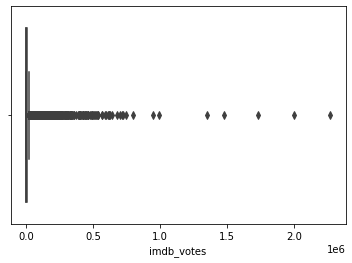

In [17]:
sns.boxplot(x='imdb_votes', data=df);

Imdb_votes has alot of outliers and a very large range from five to over two milloion. The amount of votes a show or movie gets on imdb doesnt always translate into a better imdb score.  I will check and see if this feature correlates with any of my others. 

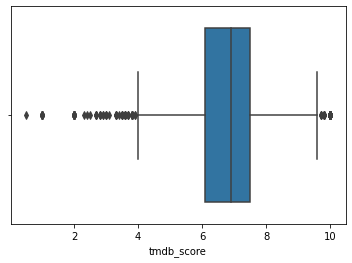

In [18]:
sns.boxplot(x='tmdb_score', data=df);

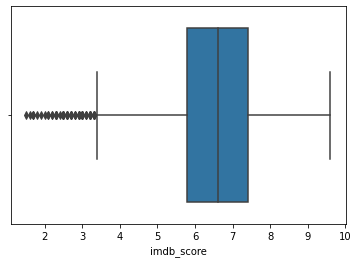

In [19]:
sns.boxplot(x='imdb_score', data=df);

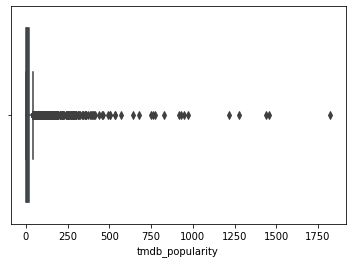

In [20]:
sns.boxplot(x='tmdb_popularity', data=df);

In [21]:
df['tmdb_popularity'].value_counts()

1.400     66
0.600     57
1.960      8
2.744      7
0.840      7
          ..
70.563     1
7.434      1
33.558     1
60.496     1
0.979      1
Name: tmdb_popularity, Length: 4943, dtype: int64

Just as we saw with imdb_score, we have a ton of outliers here, once again all on the high side. Due to this and with the concern of potentially overfitting I am going to drop this feature from my analysis.

In [22]:
df.drop(columns='tmdb_popularity',inplace=True)
df.head()

,type,release_year,runtime,genres,imdb_score,imdb_votes,tmdb_score
0,SHOW,1945,48,['documentation'],NaN,NaN,NaN
1,MOVIE,1976,113,"['crime', 'drama']",8.3,795222.0,8.2
2,MOVIE,1975,91,"['comedy', 'fantasy']",8.2,530877.0,7.8
3,MOVIE,1979,94,['comedy'],8.0,392419.0,7.8
4,MOVIE,1973,133,['horror'],8.1,391942.0,7.7


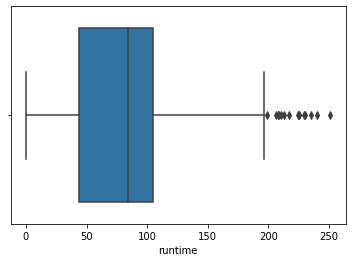

In [23]:
sns.boxplot(x='runtime', data=df);

This is not that bad, we have a few outliers but we can see that most of our programming is in the 45-110 minute time.

In [24]:
df['type'].value_counts()

MOVIE    3759
SHOW     2047
Name: type, dtype: int64

In [25]:
df['genres'].value_counts()  

['comedy']                                            510
['drama']                                             350
['documentation']                                     320
['comedy', 'drama']                                   141
['drama', 'comedy']                                   128
                                                     ... 
['drama', 'family', 'comedy', 'music']                  1
['drama', 'thriller', 'western']                        1
['comedy', 'thriller', 'drama', 'action', 'crime']      1
['romance', 'drama', 'history', 'european']             1
['family', 'comedy', 'animation']                       1
Name: genres, Length: 1626, dtype: int64

1626 values, I want to break this down into fewer values so I am going to extract just the first genre of each row. 

First I remove the unwanted text from my columns.

In [26]:
df['genres'] = df['genres'].str.replace('[','')
df['genres'] = df['genres'].str.replace(']','')
df['genres'] = df['genres'].str.replace("'",'')
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,type,release_year,runtime,genres,imdb_score,imdb_votes,tmdb_score
0,SHOW,1945,48,documentation,NaN,NaN,NaN
1,MOVIE,1976,113,"crime, drama",8.3,795222.0,8.2
2,MOVIE,1975,91,"comedy, fantasy",8.2,530877.0,7.8
3,MOVIE,1979,94,comedy,8.0,392419.0,7.8
4,MOVIE,1973,133,horror,8.1,391942.0,7.7


Now I split the target column into the data i want to keep.

In [27]:
df[['genre','2','3','4','5','6','7','8','9']]= df['genres'].str.split(', ',expand=True)
df.head()

,type,release_year,runtime,genres,imdb_score,imdb_votes,tmdb_score,genre,2,3,4,5,6,7,8,9
0,SHOW,1945,48,documentation,NaN,NaN,NaN,documentation,None,None,None,None,None,None,None,None
1,MOVIE,1976,113,"crime, drama",8.3,795222.0,8.2,crime,drama,None,None,None,None,None,None,None
2,MOVIE,1975,91,"comedy, fantasy",8.2,530877.0,7.8,comedy,fantasy,None,None,None,None,None,None,None
3,MOVIE,1979,94,comedy,8.0,392419.0,7.8,comedy,None,None,None,None,None,None,None,None
4,MOVIE,1973,133,horror,8.1,391942.0,7.7,horror,None,None,None,None,None,None,None,None


Finally I remove the old column and the excess columns.

In [28]:
df = df.drop(columns= ['genres','2','3','4','5','6','7','8','9'])
df.head()

,type,release_year,runtime,imdb_score,imdb_votes,tmdb_score,genre
0,SHOW,1945,48,NaN,NaN,NaN,documentation
1,MOVIE,1976,113,8.3,795222.0,8.2,crime
2,MOVIE,1975,91,8.2,530877.0,7.8,comedy
3,MOVIE,1979,94,8.0,392419.0,7.8,comedy
4,MOVIE,1973,133,8.1,391942.0,7.7,horror


In [29]:
df['genre'].value_counts()

drama            1432
comedy           1310
documentation     588
thriller          442
action            292
scifi             289
romance           265
crime             254
animation         232
reality           176
fantasy           143
horror            121
                   68
family             66
music              50
war                43
western            22
history             9
sport               4
Name: genre, dtype: int64

Almost perfect, got it down to just one genre for each row.  Now I'm going to impute my missing info with the mode of our set which is drama. 

In [30]:
df['genre'] = df['genre'].replace('1','drama')
df['genre'].value_counts()

drama            1432
comedy           1310
documentation     588
thriller          442
action            292
scifi             289
romance           265
crime             254
animation         232
reality           176
fantasy           143
horror            121
                   68
family             66
music              50
war                43
western            22
history             9
sport               4
Name: genre, dtype: int64

In [31]:
df['genre'].nunique()

19

Perfect, from 1626 unique values down to 19

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type          5806 non-null   object 
 1   release_year  5806 non-null   int64  
 2   runtime       5806 non-null   int64  
 3   imdb_score    5283 non-null   float64
 4   imdb_votes    5267 non-null   float64
 5   tmdb_score    5488 non-null   float64
 6   genre         5806 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 317.6+ KB


In [33]:
df['imdb_score'].value_counts()

6.6    201
6.8    199
6.5    193
6.2    192
7.4    190
      ... 
2.0      1
1.9      1
2.4      1
1.6      1
1.8      1
Name: imdb_score, Length: 81, dtype: int64

In [34]:
df['imdb_score'].describe()

count    5283.000000
mean        6.533447
std         1.160932
min         1.500000
25%         5.800000
50%         6.600000
75%         7.400000
max         9.600000
Name: imdb_score, dtype: float64

That looks good.

In [35]:
df['imdb_votes'].value_counts()

43.0        11
25.0        11
30.0         9
14.0         9
74.0         9
            ..
103.0        1
399.0        1
278223.0     1
28718.0      1
10418.0      1
Name: imdb_votes, Length: 3831, dtype: int64

In [36]:
df['imdb_votes'].describe()

count    5.267000e+03
mean     2.340719e+04
std      8.713432e+04
min      5.000000e+00
25%      5.210000e+02
50%      2.279000e+03
75%      1.014400e+04
max      2.268288e+06
Name: imdb_votes, dtype: float64

In [37]:
df['release_year'].value_counts()

2019    848
2020    805
2018    774
2021    758
2017    580
       ... 
1974      1
1959      1
1962      1
1978      1
1945      1
Name: release_year, Length: 67, dtype: int64

In [38]:
df['release_year'].describe()

count    5806.000000
mean     2016.013434
std         7.324883
min      1945.000000
25%      2015.000000
50%      2018.000000
75%      2020.000000
max      2022.000000
Name: release_year, dtype: float64

In [39]:
df['tmdb_score'].value_counts()

7.0    285
7.3    208
6.8    207
6.5    204
7.4    201
      ... 
2.3      1
3.1      1
0.5      1
3.4      1
2.5      1
Name: tmdb_score, Length: 78, dtype: int64

In [40]:
df['tmdb_score'].describe()

count    5488.000000
mean        6.818039
std         1.171560
min         0.500000
25%         6.100000
50%         6.900000
75%         7.500000
max        10.000000
Name: tmdb_score, dtype: float64

In [41]:
df_ml = df.copy() # we need a copy before any imputation to prevent data leakage
df_km = df.copy()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type          5806 non-null   object 
 1   release_year  5806 non-null   int64  
 2   runtime       5806 non-null   int64  
 3   imdb_score    5283 non-null   float64
 4   imdb_votes    5267 non-null   float64
 5   tmdb_score    5488 non-null   float64
 6   genre         5806 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 317.6+ KB


Data types are correct, we have 4 columns missing data.  As i dont want to skew the data too much i am going to use the mean of imdb_score and tmdb_score to impute for those columns.  For tmdb_popularity and imdb_votes I am going to use the median of those columns because I dont want the outliers skewing my imputation.

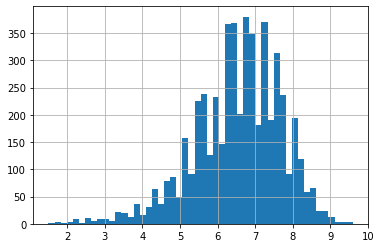

In [43]:
df['imdb_score'].hist(bins=50);

Before we impute i wanted to get a visual of how our scores are allocated. We see most shows/movies score between a rating of 6 to 8.

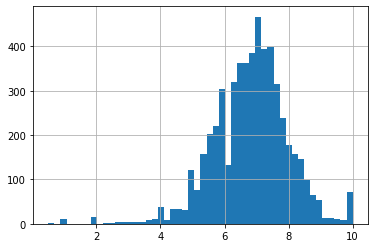

In [44]:
df['tmdb_score'].hist(bins=50);

The tmbd movie scores follow in a similar pattern.

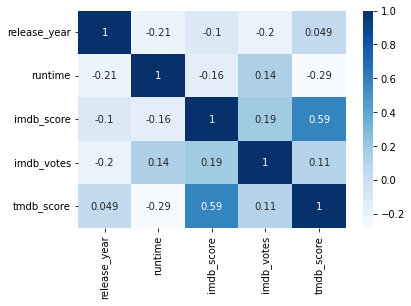

In [45]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True);

Okay so we can see the moderate correlation between imdb and tmdb scores, nothing else has a strong correlation.

In [46]:
imdb_score_mean = df['imdb_score'].mean()
df['imdb_score'].fillna(imdb_score_mean, inplace=True)
df['imdb_score'].isna().sum()

0

In [47]:
imdb_votes_median = df['imdb_votes'].median()
df['imdb_votes'].fillna(imdb_votes_median, inplace=True)
df['imdb_votes'].isna().sum()

0

In [48]:
tmdb_score_mean = df['tmdb_score'].mean()
df['tmdb_score'].fillna(tmdb_score_mean, inplace=True)
df.isna().sum()

type            0
release_year    0
runtime         0
imdb_score      0
imdb_votes      0
tmdb_score      0
genre           0
dtype: int64

Perfect, no missing data!

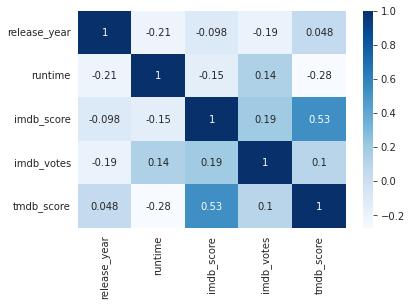

In [ ]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True);

After imputing we notice that our correlation between imdb_score and tmdb_score has gone down by a few percentage points, shouldnt be a big deal. Nothing else has changed. 

## Visuals

Our only noticable correlation thus far is between IMDB_Score and TMDB_Score. 

There is a slight correlation between 'runtime' and 'tmdb_score' at .28.

We do have a very weak correlation between imdb_votes and imdb_score. Also just as weak we have a correlation between imdb_votes and tmdb_popularity. 

In [ ]:
tmdb_score = df['tmdb_score'].values
runtime = df['runtime'].values

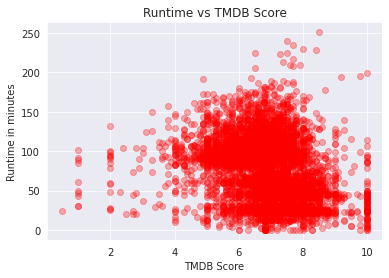

In [ ]:
plt.scatter(tmdb_score, runtime, c = 'red', alpha= .3);
plt.ylabel('Runtime in minutes');
plt.xlabel('TMDB Score')
plt.title('Runtime vs TMDB Score')
plt.show;

The darker the red, the more points there are in one spot.  This shows us our relationship between TMDB_score and runtime. The bottom right of our plot shows us that shorter shows/movies (we dont know which type they fall into) have a slightly higher TMDB_Score.

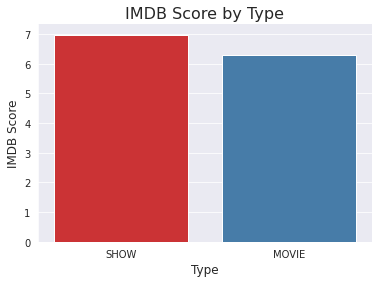

In [ ]:
sns.set_palette('Set1')
sns.set_style('darkgrid')
sns.barplot(data = df, x = 'type', y = 'imdb_score', order = ['SHOW','MOVIE'], ci=None);
plt.title('IMDB Score by Type', fontsize=16)
plt.xlabel('Type',fontsize = 12)
plt.ylabel('IMDB Score', fontsize =12 )
sns.despine();

Here we can see that while shows do a tab better on imdb score then movies do they are still very similar on score.  This means that there is a market to keep making both film and shows and we should not just focus on one or the other. 

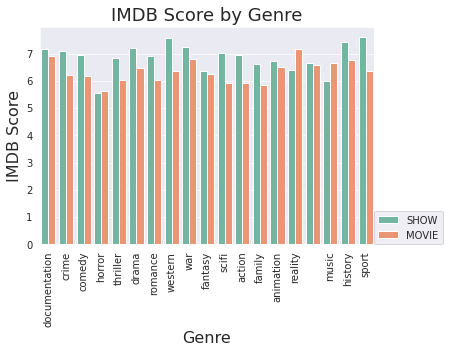

In [ ]:
sns.set_style('darkgrid')
sns.set_palette('Set2')
sns.barplot(data = df, x = 'genre', y = 'imdb_score', hue = 'type', ci=None);
plt.title('IMDB Score by Genre', fontsize=18)
plt.xlabel('Genre',fontsize = 16)
plt.ylabel('IMDB Score', fontsize =16 )
plt.legend(loc=(1,0))
plt.xticks(rotation = 90);

A further look into the imdb scores against the genres would suggest that we focus on making shows in almost all genres.  This also highlights for us that sport, history and western shows average the highest of all our data.  Furthermore we can now see exactly what genres and type of cinema we should be making overall as well as where we should stay away from such as the horror genre.

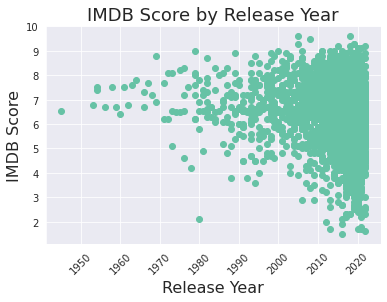

In [ ]:
plt.scatter(data = df, x = 'release_year', y = 'imdb_score')
plt.title('IMDB Score by Release Year', fontsize=18)
plt.xlabel('Release Year',fontsize = 16)
plt.ylabel('IMDB Score', fontsize =16 )
plt.xticks(rotation = 45);

Here we can see that not only are more recent movies scoring lower then ever before we also can take note that most of our data is from relativly newer movies and shows.  I think we should look at cinema from 1950-1990 and see what those have in common as the mean imdb score from those years is much higher and could help us determine what types of cinema people enjoy. 

## ML prep

In [ ]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type          5806 non-null   object 
 1   release_year  5806 non-null   int64  
 2   runtime       5806 non-null   int64  
 3   imdb_score    5283 non-null   float64
 4   imdb_votes    5267 non-null   float64
 5   tmdb_score    5488 non-null   float64
 6   genre         5806 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 317.6+ KB


I am missing data in my target column (imdb_score).  Because I cant model with missing values I am going to drop all the rows that are missing the imdb_score.

In [50]:
df_ml.dropna(subset=['imdb_score'], inplace=True)
df_ml.isna().sum()

type              0
release_year      0
runtime           0
imdb_score        0
imdb_votes       16
tmdb_score      228
genre             0
dtype: int64

Time to split, then setup selectors and pipelines, then we can impute.

In [51]:
#Validation split
X = df_ml.drop(columns=['imdb_score'])
y = df_ml['imdb_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [52]:
#making our ohe pipeline, selector(s) first
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

As I did for EDA im going to use the median of each column to impute our missing values. We want to use median because we do not want the outliers skewing the imputation.

In [53]:
# Imputers
median_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

i had originally wanted to use mean to impute my data but with so many outliers skewed on the high side of both imdb_score and tmdb_popularity im going to use median so i dont skew my data any more

In [54]:
numb_pipe = make_pipeline(median_imputer, scaler)
numb_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [55]:
cat_pipe = make_pipeline(ohe)
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

Both my object columns have all values accounted for so we wont need to impute anything for the categorical columns. 

In [56]:
numb_tup = (numb_pipe, num_selector)
cat_tup = (cat_pipe, cat_selector)
preprocessor = make_column_transformer(numb_tup, cat_tup)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9122b98050>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9120030490>)])

In [57]:
#fit on the train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9122b98050>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9120030490>)])

In [58]:
#transform and test
X_train_pro = preprocessor.transform(X_train)
X_test_pro = preprocessor.transform(X_test)
X_train_pro

array([[ 0.55607805, -1.31323184, -0.25282152, ...,  0.        ,
         0.        ,  0.        ],
       [-0.69422974,  0.98776736,  2.33045163, ...,  0.        ,
         0.        ,  0.        ],
       [-3.4726915 , -1.26152399, -0.25456164, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.69500114,  0.39312711, -0.18447061, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69500114,  0.54825066, -0.25429143, ...,  0.        ,
         0.        ,  0.        ],
       [-0.41638356, -1.41664754,  3.26010615, ...,  0.        ,
         0.        ,  0.        ]])

In [59]:
np.isnan(X_train_pro).sum().sum()

0

In [60]:
np.isnan(X_test_pro).sum().sum()

0

We are not missing any data in our X_sets so we are ready for modeling.

##KMeans  
Well start with an unsupervised model.

For KMeans there is no train split so I'm going to rerun my preprocessor to impute my data so I can model it again.

In [ ]:
df_km.info() #using the copy we made earlier with no yet imputed data and no train test split.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type          5806 non-null   object 
 1   release_year  5806 non-null   int64  
 2   runtime       5806 non-null   int64  
 3   imdb_score    5283 non-null   float64
 4   imdb_votes    5267 non-null   float64
 5   tmdb_score    5488 non-null   float64
 6   genre         5806 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 317.6+ KB


So here we have our unimputed data, for supervised ML we will have to drop our target column but here we do not.

In [ ]:
x_scaled = preprocessor.fit_transform(df_km)

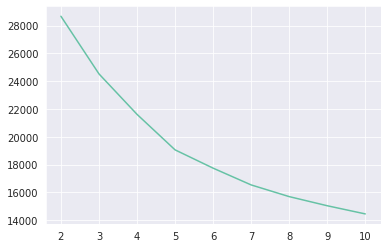

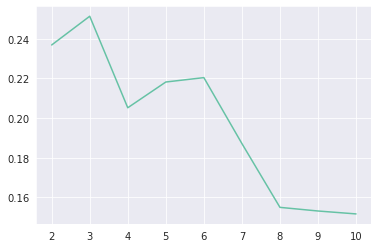

In [ ]:
ks = range(2, 11)

inertias = []
sils = []

for k in ks:
  model = KMeans(n_clusters=k)
  model.fit(x_scaled)
  inertias.append(model.inertia_)
  sils.append(silhouette_score(x_scaled, model.labels_))

plt.plot(ks, inertias)

plt.show()

plt.plot(ks, sils);

Our inertia graph doesnt have clear elbow but our silhouette score gives us a very defined number of clusters with 4.

In [ ]:
kmeans_model = KMeans(n_clusters=4, random_state=42)

kmeans_model.fit(x_scaled)

KMeans(n_clusters=4, random_state=42)

Before going forward I just want to plot our clusters and see if we can learn anything about our features relationships.

In [ ]:
df_km['cluster'] = kmeans_model.labels_
cluster_groups = df_km.groupby('cluster', as_index=False).mean()
cluster_groups

,cluster,release_year,runtime,imdb_score,imdb_votes,tmdb_score
0,0,1995.796143,112.953168,7.010057,182167.060345,6.878151
1,1,2017.060081,103.257128,6.898885,15650.595757,6.966885
2,2,2017.670208,37.603090,7.093119,11965.787507,7.590541
3,3,2017.328835,91.708807,5.168060,7795.269663,5.522125


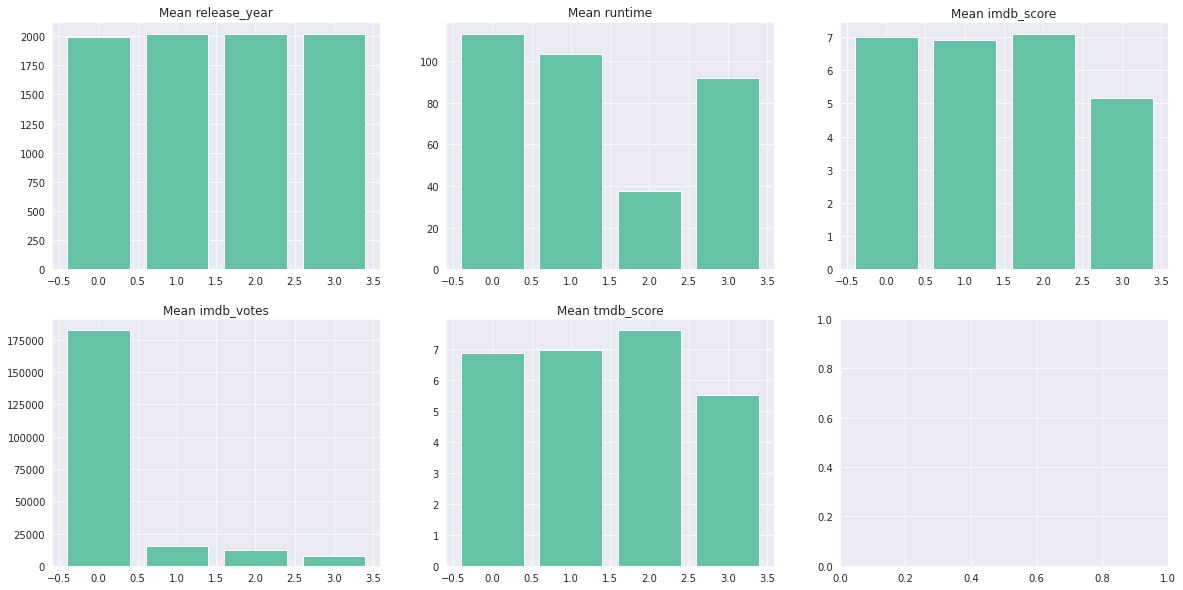

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (20, 10))
axes = axes.ravel()
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

##Supervised Modeling
## Bagging Regressor

In [61]:
bagreg = BaggingRegressor(random_state = 42)

In [62]:
bagreg.fit(X_train_pro, y_train)

BaggingRegressor(random_state=42)

In [63]:
bagreg.predict(X_test_pro)

array([6.66, 6.91, 6.64, ..., 6.07, 6.99, 6.78])

In [64]:
bagreg_train_score = bagreg.score(X_train_pro, y_train)
bagreg_test_score = bagreg.score(X_test_pro, y_test)
print(bagreg_train_score)
print(bagreg_test_score)

0.9028410061852925
0.47347207838098415


This model is extremly overfit, I'm going to tune it and see if I can get better results.

In [65]:
# List of estimator values
estimators = [10, 20, 30, 40, 50, 100]
# Data frame to store the scores
scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])
# Iterate through the values to find the best number of estimators
for num_estimators in estimators:
   bag_reg = BaggingRegressor(n_estimators=num_estimators, random_state=42)
   bag_reg.fit(X_train_pro, y_train)
   train_score = bag_reg.score(X_train_pro, y_train)
   test_score = bag_reg.score(X_test_pro, y_test)
   scores.loc[num_estimators, 'Train Score'] = train_score
   scores.loc[num_estimators, 'Test Score'] = test_score

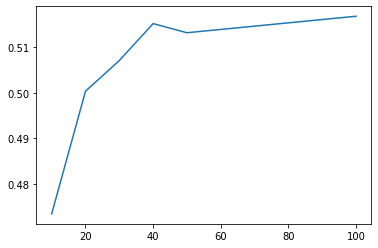

In [66]:
# Plot the scores
plt.plot(scores['Test Score'])
plt.show()

Sorting my scores next.

In [67]:
scores = scores.sort_values(by='Test Score', ascending=False)
scores

,Train Score,Test Score
100,0.929747,0.516729
40,0.925665,0.515119
50,0.927371,0.51312
30,0.923319,0.507033
20,0.917032,0.500317
10,0.902841,0.473472


With 100 being the best I'm going to retest with similar numbers.

In [68]:
# List of estimator values
estimators = [100, 120, 130, 140, 150]
# Data frame to store the scores
scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])
# Iterate through the values to find the best number of estimators
for num_estimators in estimators:
   bag_reg = BaggingRegressor(n_estimators=num_estimators, random_state=42)
   bag_reg.fit(X_train_pro, y_train)
   train_score = bag_reg.score(X_train_pro, y_train)
   test_score = bag_reg.score(X_test_pro, y_test)
   scores.loc[num_estimators, 'Train Score'] = train_score
   scores.loc[num_estimators, 'Test Score'] = test_score

In [69]:
scores = scores.sort_values(by='Test Score', ascending=False)
scores

,Train Score,Test Score
140,0.930821,0.51845
150,0.931048,0.5183
120,0.930576,0.517578
130,0.930777,0.517549
100,0.929747,0.516729


In [70]:
bag_reg_final = BaggingRegressor(n_estimators=150, random_state=42)
bag_reg_final.fit(X_train_pro, y_train)
train_final = bag_reg_final.score(X_train_pro, y_train)
test_final = bag_reg_final.score(X_test_pro, y_test)
print(train_score)
print(test_score)

0.9310481979873222
0.5182999667667687


So even with 150 estimators we are not getting very much in the way of return on our test data (only a .004% increase.)  Lets try a different model.

##Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(random_state = 42)

In [ ]:
rf.fit(X_train_pro, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
rf.predict(X_test_pro)

array([6.605, 6.903, 6.529, ..., 6.022, 6.994, 6.554])

In [ ]:
rf_train_score = rf.score(X_train_pro, y_train)
rf_test_score = rf.score(X_test_pro, y_test)
print(rf_train_score)
print(rf_test_score)

0.9295891608576191
0.5159871628119488


We are still very overfit.  Lets try changing our depth.

In [ ]:
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

44

In [ ]:
depths = range(1, max(est_depths))
scores = pd.DataFrame(index=depths, columns=['Test Score'])
for depth in depths:    
   model = RandomForestRegressor(max_depth=depth)
   model.fit(X_train_pro, y_train)
   scores.loc[depth, 'Train Score'] = model.score(X_train_pro, y_train)
   scores.loc[depth, 'Test Score'] = model.score(X_test_pro, y_test)
   scores.head()

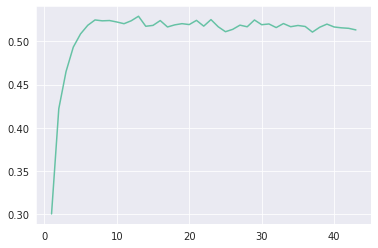

In [ ]:
plt.plot(scores['Test Score']);

In [ ]:
rf_scores = scores.sort_values(by='Test Score', ascending=False)
rf_scores.head()

,Test Score,Train Score
13,0.529218,0.871747
23,0.525325,0.930488
7,0.524918,0.641692
29,0.524891,0.931380
21,0.524435,0.930235


30 is our best depth so lets start with that and move on to tuning our number of estimators.

In [ ]:
n_ests = [50, 100, 150, 200, 250]
scores2 = pd.DataFrame(index=n_ests, columns=['Test Score', 'Train Score'])
for n in n_ests:
   model = RandomForestRegressor(max_depth=13, n_estimators=n)
   model.fit(X_train_pro, y_train)
   scores2.loc[n, 'Train Score'] = model.score(X_train_pro, y_train)
   scores2.loc[n, 'Test Score'] = model.score(X_test_pro, y_test)
scores2.head()

,Test Score,Train Score
50,0.517461,0.869451
100,0.527712,0.87437
150,0.525626,0.873284
200,0.525061,0.875074
250,0.526114,0.875111


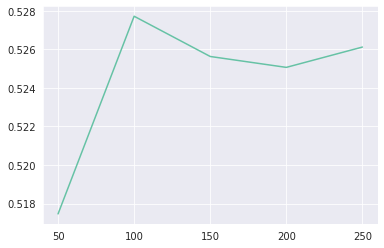

In [ ]:
plt.plot(scores2['Test Score'])
plt.xticks(n_ests);

In [ ]:
sorted_scores2 = scores2.sort_values(by='Test Score', ascending=False)
sorted_scores2.head()

,Test Score,Train Score
100,0.527712,0.87437
250,0.526114,0.875111
150,0.525626,0.873284
200,0.525061,0.875074
50,0.517461,0.869451


In [ ]:
rf_model = RandomForestRegressor(max_depth=21, n_estimators=100)
rf_model.fit(X_train_pro, y_train)
rf_train_final_score = rf_model.score(X_train_pro, y_train)
rf_test_final_score = rf_model.score(X_test_pro, y_test)
print(rf_train_final_score)
print(rf_test_final_score)
print(rf_train_score)
print(rf_test_score)

0.9284571850284876
0.5178402433042641
0.9295891608576191
0.5159871628119488


Due to overfitting I am going to try using GridSearchCV.

In [ ]:
model = RandomForestRegressor()
 
param_grid = {'max_depth': [30,35,40],
              'min_samples_leaf': [3,15,20],
              'min_samples_split': [2, 10, 100]}

In [ ]:
dt_grid_search = GridSearchCV(model, param_grid)

In [ ]:
dt_grid_search.fit(X_train_pro, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [30, 35, 40],
                         'min_samples_leaf': [3, 15, 20],
                         'min_samples_split': [2, 10, 100]})

In [ ]:
dt_grid_search.best_params_

{'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 10}

In [ ]:
param_grid2 = {'max_depth': [30, 40, 50],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [10,15,20]}
 
dt_grid_search2 = GridSearchCV(model, param_grid2)
dt_grid_search2.fit(X_train_pro, y_train)
dt_grid_search2.best_params_

{'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 15}

In [ ]:
best_model = dt_grid_search2.best_estimator_
best_model.fit(X_train_pro, y_train)

best_model.score(X_test_pro, y_test)

0.5365803186175382

So here we can see that our basic model is very close to our tuned model in terms of prediction.

Perhaps some PCA feature extraction can help us. The X_train_pro is already scaled so we can just run PCA and our model.

In [ ]:
pca = PCA(n_components=.80)

In [ ]:
%%time
pca_pipe = make_pipeline(pca, rf_model)
pca_pipe.fit(X_train_pro, y_train)

CPU times: user 3.08 s, sys: 124 ms, total: 3.2 s
Wall time: 3.08 s


In [ ]:
pca_preds = pca_pipe.predict(X_test_pro)

In [ ]:
print('Training accuracy:', pca_pipe.score(X_train_pro, y_train))
print('Testing accuracy:', pca_pipe.score(X_test_pro, y_test))

Training accuracy: 0.9176934079631582
Testing accuracy: 0.459048443571752


So here we see that our model has done even worse now with the addition of PCA.

## Metrics

### Bag metrics

In [71]:
bag_train_pred = bag_reg_final.predict(X_train_pro)
bag_test_pred = bag_reg_final.predict(X_test_pro)

In [72]:
train_r2 = np.corrcoef(y_train, bag_train_pred)[0][1]**2
test_r2 = np.corrcoef(y_test, bag_test_pred)[0][1]**2
print(f'Model Trainging R2: {train_r2}')
print(f'Model Testing R2: {test_r2}')

Model Trainging R2: 0.9450437669226899
Model Testing R2: 0.521891721943893


So this is ok news the model can account for almost 95% of the variance in the y_test.

In [73]:
bag_train_MSE = mean_squared_error(y_train, bag_train_pred)
bag_test_MSE = mean_squared_error(y_test, bag_test_pred)
print(f'Model Training MSE: {bag_train_MSE}')
print(f'Model Testing MSE: {bag_test_MSE}')

Model Training MSE: 0.09233627393572276
Model Testing MSE: 0.6608002506518632


Our model is a bit overfit but on the testing set we can see we are only off by about .61 points. 

In [75]:
train_MAE = mean_absolute_error(y_train, bag_train_pred)
test_MAE = mean_absolute_error(y_test, bag_test_pred)
print(f'Model Training MAE: {train_MAE}')
print(f'Model Testing MAE: {test_MAE}')

Model Training MAE: 0.21642840316338569
Model Testing MAE: 0.5747832450164019


In [74]:
bag_train_RMSE = np.sqrt(bag_train_MSE)
bag_test_RMSE = np.sqrt(bag_test_MSE)
print(f'Model Training RMSE: {bag_train_RMSE}')
print(f'Model Testing RMSE: {bag_test_RMSE}')

Model Training RMSE: 0.30386884331191766
Model Testing RMSE: 0.8128962114881968


RMSE again shows us we are overfit but a little bit less so then MSE told us.  The predictions  are  off by only .81 points so we are close.

## Deep Learning
### Due to my constant overfitting I am going to try some deep modeling.

In [ ]:
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [ ]:
X_train_pro.shape

(3962, 25)

In [ ]:
input_dim = X_train_pro.shape[1]
 
model_1 = Sequential()
 
model_1.add(Dense(25, input_dim=input_dim, activation='relu'))
model_1.add(Dense(18, activation='relu'))
model_1.add(Dense(1, activation='linear'))
 
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 25)                650       
                                                                 
 dense_21 (Dense)            (None, 18)                468       
                                                                 
 dense_22 (Dense)            (None, 1)                 19        
                                                                 
Total params: 1,137
Trainable params: 1,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss='mse',
                  optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

In [ ]:
history = model.fit(X_train_pro, y_train,
                        validation_data = (X_test_pro, y_test),
                        epochs=100,
                        verbose=0)

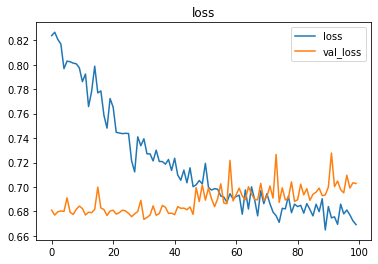

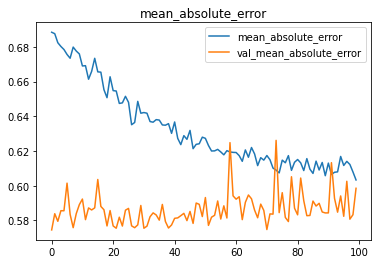

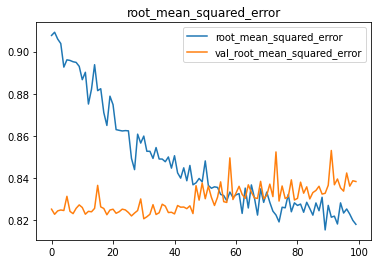

In [ ]:
plot_history(history)

In [ ]:
y_pred = model_1.predict(X_test_pro)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

final RMSE: 6.513948501578932
final MAE: 6.4123233318285635
final R2: -29.931082458880255


Lets tune it, I'm going to introduce early stopping and dropout.

In [ ]:
input_dim = X_train_pro.shape[1]
 
model = Sequential()
 
model.add(Dense(25, input_dim=input_dim, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
 
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 25)                650       
                                                                 
 dense_24 (Dense)            (None, 18)                468       
                                                                 
 dropout_7 (Dropout)         (None, 18)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 19        
                                                                 
Total params: 1,137
Trainable params: 1,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse',
                  optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

In [ ]:
early_stopping = EarlyStopping(patience = 3)

In [ ]:
history_final = model.fit(X_train_pro, y_train,
                        validation_data = (X_test_pro, y_test),
                        epochs=30,
                        verbose=0,
                        callbacks = early_stopping)

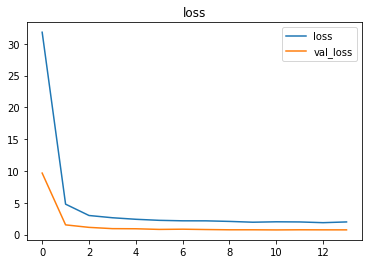

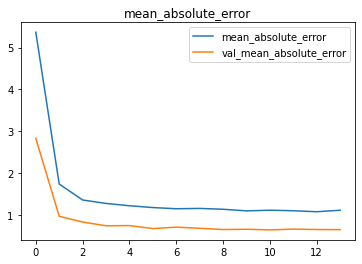

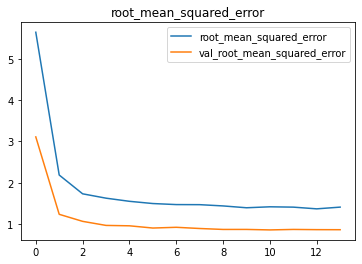

In [ ]:
plot_history(history_final)

In [ ]:
y_pred = model.predict(X_test_pro)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

final RMSE: 0.8675603065739499
final MAE: 0.6437068094546645
final R2: 0.45133680984289626


So our tuned model performs alot better then the untuned iteration.  I've substantially lowered RMSE and MAE. However even tuned the bagging model did just a bit better.

## Conclusion
Based off of the tuned RMSE score of the bagging model I would conclude we can use this model to predict future IMDB scores of new movies or shows.  Being only off by .8 points on a base 10 scale means we have good confidance this model will tell us how we can expect IMDB users to vote upcoming films and shows.
